In [17]:
# 모듈 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import re
from nltk.corpus import stopwords
from nltk import pos_tag # 품사 분류
from nltk.tokenize import word_tokenize # 단어 토큰화
from nltk.stem import WordNetLemmatizer
from collections import Counter
import joblib

import platform
import sys
MODULE_PATH = '/Users/anhyojun/VSCode/K-Digital Training/MyModule'
sys.path.append(MODULE_PATH)
from KDTModule import *

import nltk
# nltk.download('stopwords') # 불용어 목록 다운로드 해야 함
# nltk.download('punkt') # 토큰화 할때 필요
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('wordnet')

In [18]:
# 시드 설정
torch.manual_seed(1)

In [19]:
# 데이터 불러오기
PATH = 'twitter/Twitter_Data.csv'
twitter = pd.read_csv(PATH)
twitter

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [20]:
# 데이터 프레임 정보 확인
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [21]:
# 결측치 확인
twitter.isna().sum()

clean_text    4
category      7
dtype: int64

In [22]:
# 결측치 제거
twitter.dropna(inplace = True)
twitter.isna().sum()

clean_text    0
category      0
dtype: int64

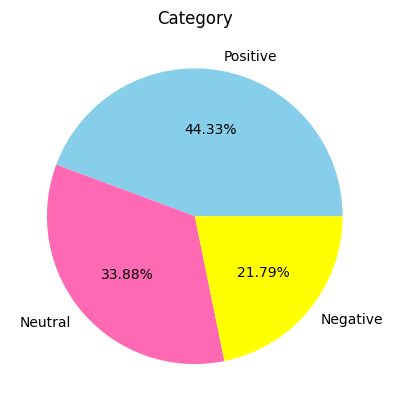

In [23]:
# 타겟 레이블 비율 시각화
plt.pie(twitter['category'].value_counts(), labels = ['Positive', 'Neutral', 'Negative'],
        autopct = '%.2f%%', colors = ['skyblue', 'hotpink', 'yellow'])
plt.title('Category')
plt.show()

> 긍정 : 44.33%, 중립 : 33.88%, 부정 : 21.79%

In [24]:
# 타겟 레이블 범주 (0, 1, 2)로 바꾸기
twitter['category'] = twitter['category'].replace(-1, 2)
twitter # 0: 중립, 1: 긍정, 2: 부정

,clean_text,category
0,when modi promised “minimum government maximum...,2.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,2.0
162976,dear rss terrorist payal gawar what about modi...,2.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [25]:
# 훈련, 검증, 테스트 데이터 분리
featureDF = twitter[['clean_text']]
targetDF = twitter[['category']]

train_inputDF, test_inputDF, train_targetDF, test_targetDF = train_test_split(featureDF, targetDF,
                                                                      stratify = targetDF,
                                                                      train_size = 0.8, random_state = 42)
train_inputDF, valid_inputDF, train_targetDF, valid_targetDF = train_test_split(train_inputDF, train_targetDF,
                                                                        stratify = train_targetDF,
                                                                        train_size = 0.8, random_state = 42)

In [26]:
print(f"[train] input : {train_inputDF.shape}, target : {train_targetDF.shape}")
print(f"[valid] input : {valid_inputDF.shape}, target : {valid_targetDF.shape}")
print(f"[test] input : {test_inputDF.shape}, target : {test_targetDF.shape}")

[train] input : (104300, 1), target : (104300, 1)
[valid] input : (26075, 1), target : (26075, 1)
[test] input : (32594, 1), target : (32594, 1)


In [27]:
vectorizer = TfidfVectorizer(max_features = 8000) 
a = []
b = vectorizer.fit_transform(train_inputDF['clean_text'])
for i in b:
    a.append(i)
    break

In [28]:
for i in a:
    print(i)

  (0, 5468)	0.15041694187914165
  (0, 3654)	0.17953274843671835
  (0, 830)	0.21785044377678014
  (0, 6998)	0.1464670857178489
  (0, 6565)	0.1277816210283111
  (0, 145)	0.1930593246697183
  (0, 5586)	0.28578882391942545
  (0, 410)	0.13074628859946594
  (0, 3570)	0.27517323819154965
  (0, 7189)	0.13623095983367775
  (0, 4246)	0.19474084976970554
  (0, 2593)	0.12909761867496797
  (0, 1663)	0.11192951485241506
  (0, 2955)	0.2646632944984971
  (0, 190)	0.20517555842941235
  (0, 5419)	0.14807190050576555
  (0, 1773)	0.28334930656537366
  (0, 383)	0.10077258789365863
  (0, 1541)	0.2789879224794591
  (0, 4740)	0.21364434875483676
  (0, 2009)	0.18673474234738682
  (0, 4925)	0.14785114664590265
  (0, 7203)	0.23672517340473093
  (0, 7971)	0.08591726747128127
  (0, 7879)	0.1932328937647013
  (0, 335)	0.18788876830674373
  (0, 4500)	0.14725219094833883


In [29]:
vectorizer.get_feature_names_out()[5468]

'poor'

In [30]:
train_inputDF

,clean_text
36700,many agree with you the need defeat the modish...
147465,maam always read you articles spite the fact n...
160363,simple words modi accepting the defeat after g...
86548,please maintain the dignity prime ministerthis...
73107,unlike modi’ india canada did not withdraw dol...
...,...
73817,patel for your information present narendra mo...
91666,solution will need dialogue with strong commit...
60949,lok sabha elections 2019 narendra modi start h...
158586,east aur west modi the best


In [31]:
train_inputDF['clean_text'][36700]

'many agree with you the need defeat the modishah combine all costs please accept seatsharing formula with the congress even less than ideal also principle aap should support the basic income poor'

In [32]:
vectorizer = TfidfVectorizer(max_features = 8000) # 최대 8000개의 특징 선택
train_vectors = vectorizer.fit_transform(train_inputDF['clean_text']).toarray()
valid_vectors = vectorizer.transform(valid_inputDF['clean_text']).toarray()
test_vectors = vectorizer.transform(test_inputDF['clean_text']).toarray()

joblib.dump(vectorizer, 'tfid_vectorizer.pkl')

['tfid_vectorizer.pkl']

In [33]:
train_vectorsDF = pd.DataFrame(train_vectors)
valid_vectorsDF = pd.DataFrame(valid_vectors)
test_vectorsDF = pd.DataFrame(test_vectors)
train_vectorsDF

,0,1,2,3,4,5,6,7,8,9,...,7990,7991,7992,7993,7994,7995,7996,7997,7998,7999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
trainDS = CustomDataset(train_vectorsDF, train_targetDF, feature_dim=2)
validDS = CustomDataset(valid_vectorsDF, valid_targetDF, feature_dim=2)
testDS = CustomDataset(test_vectorsDF, test_targetDF, feature_dim=2)

trainDL = DataLoader(trainDS, batch_size=64)
validDL = DataLoader(validDS, batch_size=64)
testDL = DataLoader(testDS, batch_size=64)

In [37]:
trainDL.dataset[0]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1.]))

In [66]:
for X_batch, y_batch in trainDL:
    print(X_batch.shape)  # X_batch의 차원 출력
    break  # 첫 번째 배치만 확인하기 위해 루프를 중지

torch.Size([64, 1, 8000])


In [40]:
trainDL.dataset[0][0].shape

torch.Size([1, 8000])

In [67]:
model = LSTMModel(input_size = 8000, output_size = 3, hidden_list = [100, 80, 60, 40, 20],
                  act_func=F.relu, model_type='multiclass', num_layers=1)
# num_layers : 재귀층(Recurrent Layer)의 개수 (기본적인 LSTM 모델에서는 1개)

In [68]:
adam_optim = optim.Adam(model.parameters(), lr = 0.0001)

In [69]:
# 모델 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/VSCode/K-Digital Training/김소현 강사님/프로젝트/4번째 프로젝트/model'
result = training(trainDL, validDL, model, 'multiclass', adam_optim, EPOCH,
                  endurance_cnt=5, num_classes=3, SAVE_PATH=SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 0.8843, Test : 0.5985
[Score  : 1/100] Train : 0.5607, Test : 0.7376
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 0.4692, Test : 0.3526
[Score  : 2/100] Train : 0.7998, Test : 0.8802
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/100] Train : 0.2443, Test : 0.2529
[Score  : 3/100] Train : 0.9210, Test : 0.9223
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/100] Train : 0.1725, Test : 0.2228
[Score  : 4/100] Train : 0.9506, Test : 0.9350
[EPOCH] : 5에서 모델 저장 완료.
[Loss : 5/100] Train : 0.1432, Test : 0.2140
[Score  : 5/100] Train : 0.9619, Test : 0.9383
[Loss : 6/100] Train : 0.1273, Test : 0.2143
[Score  : 6/100] Train : 0.9680, Test : 0.9384
[Loss : 7/100] Train : 0.1166, Test : 0.2202
[Score  : 7/100] Train : 0.9719, Test : 0.9372
[Loss : 8/100] Train : 0.1087, Test : 0.2280
[Score  : 8/100] Train : 0.9747, Test : 0.9355
[Loss : 9/100] Train : 0.1025, Test : 0.2373
[Score  : 9/100] Train : 0.9766, Test : 0.9333
[Loss]값의 개선이 이루어지지 않아 [10] EPOCH에서 학습을 종료합니다.


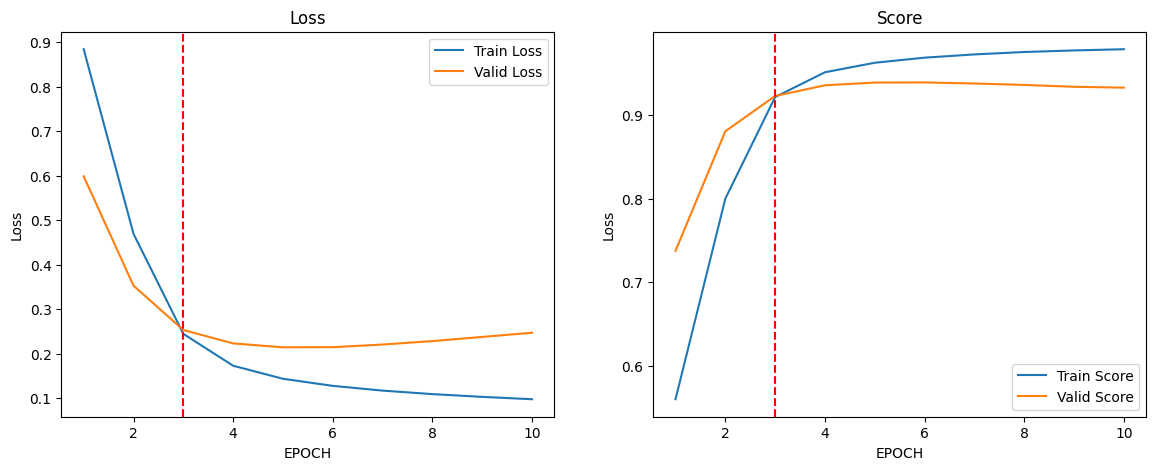

In [70]:
fig, axs = DrawPlot(result)
axs[0].axvline(x=3, color='red', linestyle='--')
axs[1].axvline(x=3, color='red', linestyle='--')
plt.show()

In [71]:
sentence = 'I hate You'

sentenceDF = pd.DataFrame([sentence], columns=['clean_text'])
loaded_vectorizer = joblib.load('tfid_vectorizer.pkl')
input_vector = loaded_vectorizer.transform(sentenceDF['clean_text']).toarray()
input_vectorDF = pd.DataFrame(input_vector)
best_model = LSTMModel(input_size = 8000, output_size = 3, hidden_list = [100, 80, 60, 40, 20],
                  act_func=F.relu, model_type='multiclass', num_layers=1)
best_model.load_state_dict(torch.load('Best_LSTM_Model.pth', weights_only=True))
predict_value(input_vectorDF, best_model, dim=3)

tensor([2])

In [72]:
test_vectorsTS = torch.FloatTensor(test_vectorsDF.values)
test_vectorsTS3D = test_vectorsTS.reshape(-1,1,8000)

predictTS = torch.argmax(best_model(test_vectorsTS3D), dim=1)
test_targetTS = torch.FloatTensor(test_targetDF.values)

answer_count = 0
for i in range(len(predictTS)):
    if predictTS[i] == test_targetTS.reshape(-1)[i]:
        answer_count += 1

print(f"[Test Accuracy] : {answer_count / len(predictTS)}")

[Test Accuracy] : 0.923145364177456


In [73]:
y_test = test_targetTS.reshape(-1).tolist()
y_pred = predictTS.tolist()

print(f"{'-'*18}테스트 세트 평가 지표{'-'*18}\n{classification_report(y_test, y_pred)}")

------------------테스트 세트 평가 지표------------------
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     11042
         1.0       0.93      0.96      0.94     14450
         2.0       0.89      0.82      0.85      7102

    accuracy                           0.92     32594
   macro avg       0.92      0.91      0.91     32594
weighted avg       0.92      0.92      0.92     32594



In [74]:
prob = F.softmax(best_model(test_vectorsTS3D), dim=1)
prob

tensor([[9.4770e-01, 5.0048e-03, 4.7290e-02],
        [9.4138e-01, 1.8142e-02, 4.0473e-02],
        [1.5091e-04, 9.6940e-01, 3.0445e-02],
        ...,
        [5.5529e-04, 9.5091e-01, 4.8535e-02],
        [4.2552e-04, 9.5515e-01, 4.4422e-02],
        [6.8317e-02, 8.6519e-01, 6.6490e-02]], grad_fn=<SoftmaxBackward0>)

In [75]:
y_test_int = list(map(int, y_test))
y_test_onehot = np.eye(3)[y_test_int]
y_test_onehot

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [76]:
roc_auc_score(y_test_onehot, prob.detach().numpy(), multi_class='ovr')

0.9781819498267373